### Классификация, кластеризация и AI суммаризация звонков

Batches:   0%|          | 0/181 [00:00<?, ?it/s]

Текстов в кластерах: {0: np.int64(236), 1: np.int64(243), 2: np.int64(243)}
Кластер 0 - распределение классов: {'Кузовной ремонт': 96, 'Нецелевой звонок': 3, 'Покупка автомобиля': 6, 'Сервис и обслуживание автомобиля': 130, 'Финансовые вопросы': 1}
Кластер 1 - распределение классов: {'Вопрос оператору': 80, 'Покупка автомобиля': 13, 'Нецелевой звонок': 109, 'Сервис и обслуживание автомобиля': 20, 'Финансовые вопросы': 7, 'Кузовной ремонт': 14}
Кластер 2 - распределение классов: {'Вопрос оператору': 25, 'Покупка автомобиля': 90, 'Кузовной ремонт': 1, 'Сервис и обслуживание автомобиля': 1, 'Финансовые вопросы': 124, 'Нецелевой звонок': 2}


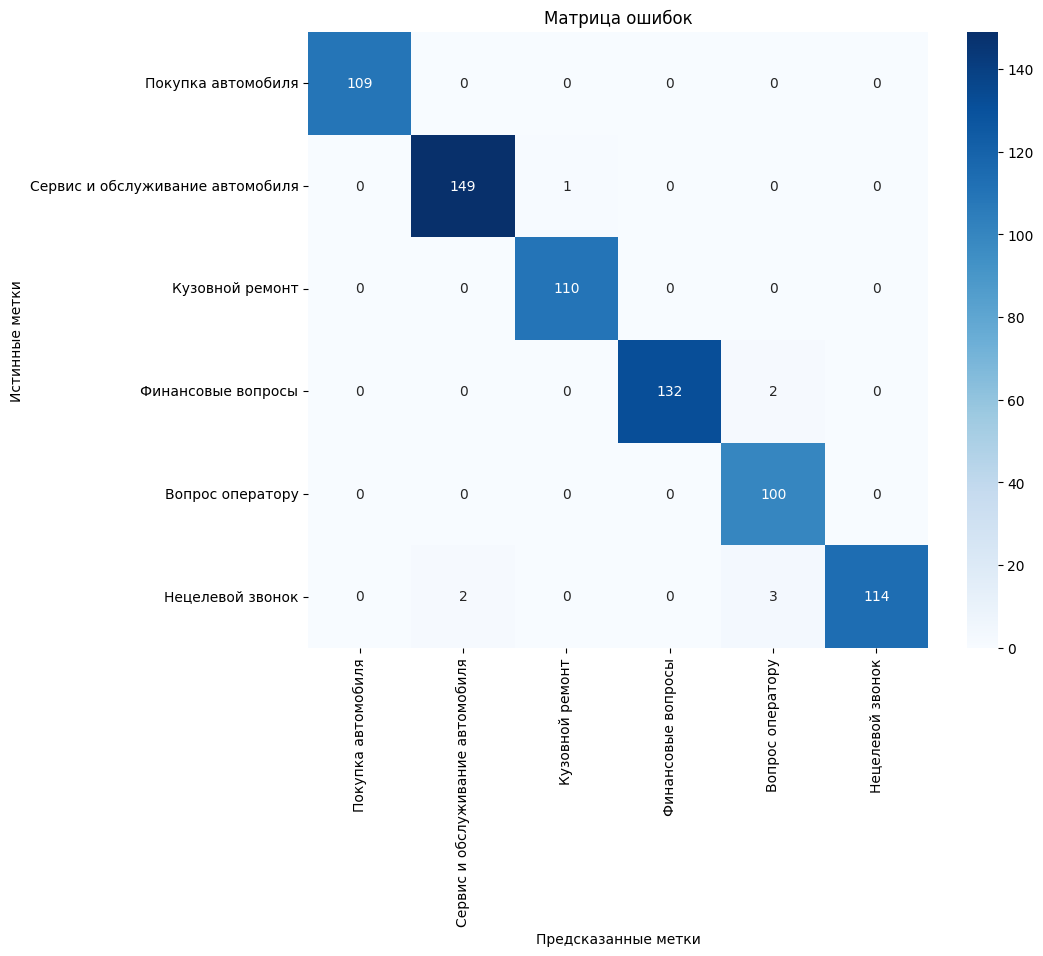

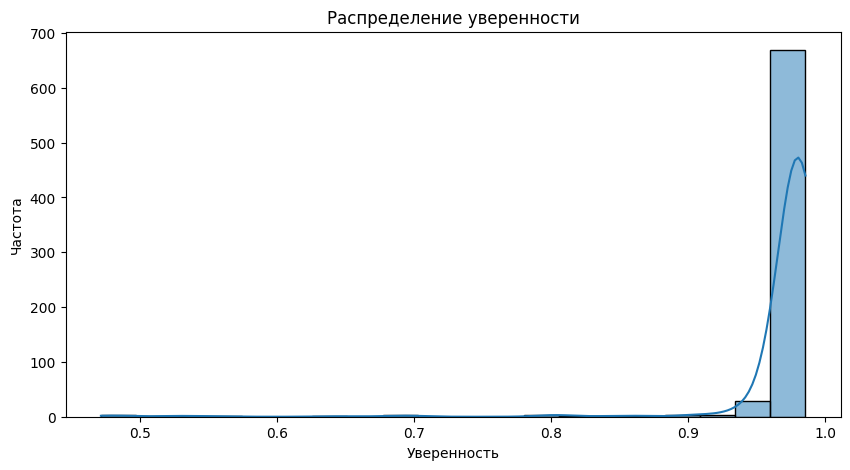


=== Суммаризация по классам ===

Класс: Покупка автомобиля
Обобщение: Клиенты интересуются различными аспектами приобретения автомобилей, от связи с менеджером по продажам до покупки машин в кредит или в рассрочку, а также ищут информацию о ценах, скидках и программах трейд-ин. 1) Связь с менеджером по продажам, 2) Покупка автомобиля в кредит или рассрочку, 3) Интерес к ценам и скидкам, 4) Интерес к новым и подержанным автомобилям.
Ключевые пункты: 1) Клиенты интересуются различными аспектами приобретения автомобилей, от связи с менеджером по продажам до покупки машин в кредит или в рассрочку, а также ищут информацию о ценах, скидках и программах трейд-ин. 1) Связь с менеджером по продажам, 2) Покупка автомобиля в кредит или рассрочку, 3) Интерес к ценам и скидкам, 4) Интерес к новым и подержанным автомобилям.

Класс: Сервис и обслуживание автомобиля
Обобщение: Клиенты автосервиса заинтересованы в проведении различных технических работ, включая диагностику и ремонт двигателя, замену м

Batches:   0%|          | 0/181 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


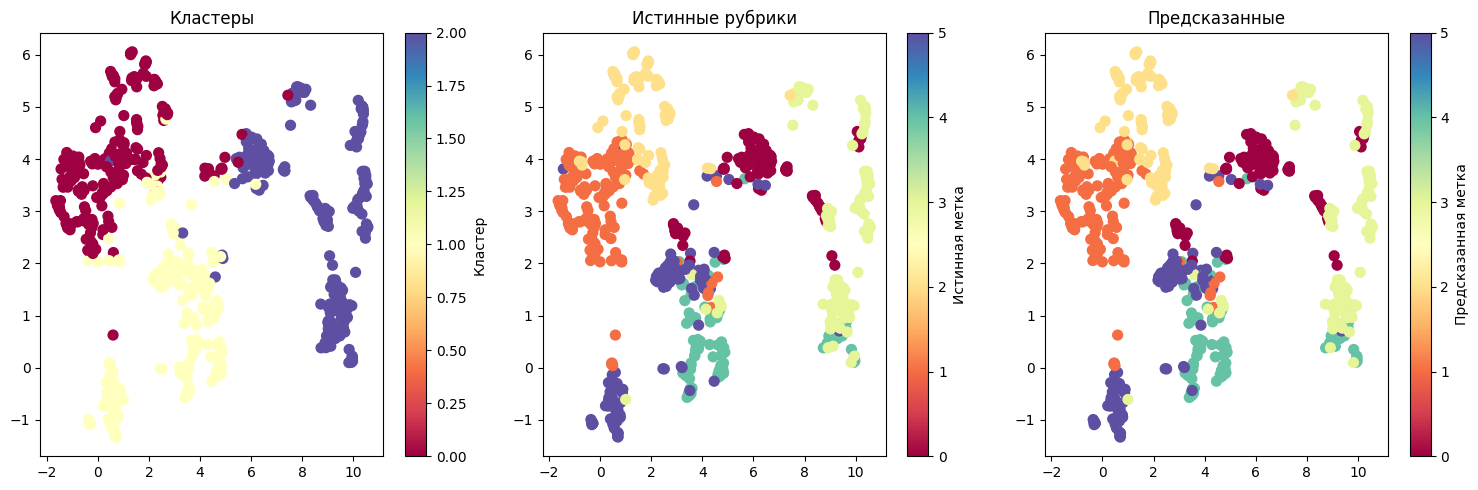

In [ ]:
# Установка библиотек для colab
# !pip install sentence-transformers transformers torch scikit-learn seaborn matplotlib pandas langgraph umap-learn sacremoses hf_xet huggingface_hub -q

# обученную модель кдля классификации model.onnx предлагаю брать из репозитория Docker Hub: gravekgit/small_projects:agcalls-app


# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import torch
import gc
import re
from sentence_transformers import SentenceTransformer
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, END
from collections import Counter
from openai import OpenAI

# Определение категорий
CATEGORIES = [
    "Покупка автомобиля",
    "Сервис и обслуживание автомобиля",
    "Кузовной ремонт",
    "Финансовые вопросы",
    "Вопрос оператору",
    "Нецелевой звонок"
]

# Определение состояния
class AgentState(TypedDict):
    texts: List[str]
    true_labels: List[str]
    predicted_labels: List[str]
    clusters: List[int]
    summary_by_class: Dict[str, Dict[str, str]]
    summary_by_cluster: Dict[str, str]
    performance_metrics: Dict[str, float]
    confidences: List[float]

# Кастомная модель
class CustomSentenceTransformer(nn.Module):
    def __init__(self, base_model, num_labels):
        super(CustomSentenceTransformer, self).__init__()
        self.base_model = base_model
        self.classifier = nn.Linear(base_model.get_sentence_embedding_dimension(), num_labels).float()

    def forward(self, inputs):
        outputs = self.base_model(inputs)
        if isinstance(outputs, dict) and "sentence_embedding" in outputs:
            embeddings = outputs["sentence_embedding"].float()
        else:
            raise ValueError(f"Expected 'sentence_embedding' in outputs, got {type(outputs)}")
        logits = self.classifier(embeddings)  # Исправлено: embeddings вместо embedings
        return logits

# classify_agent
def classify_agent(state: AgentState) -> AgentState:
    if not state["texts"]:
        raise ValueError("state['texts'] пустой")
    if not all(isinstance(text, str) for text in state["texts"]):
        raise ValueError("state['texts'] содержит нестроковые элементы")

    valid_texts = [text for text in state["texts"] if text.strip()]
    if len(valid_texts) != len(state["texts"]):
        print(f"Предупреждение: пропущено {len(state['texts']) - len(valid_texts)} пустых текстов")
    if not valid_texts:
        raise ValueError("Все тексты пустые или некорректные")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)
    model = CustomSentenceTransformer(base_model, len(CATEGORIES)).to(device).float()
    try:
        model.load_state_dict(torch.load("/content/best_model.pt", map_location=device))
    except Exception as e:
        raise ValueError(f"Ошибка загрузки модели best_model.pt: {e}")
    model.eval()

    predicted_labels = []
    confidences = []
    batch_size = 4

    for i in range(0, len(valid_texts), batch_size):
        batch_texts = valid_texts[i:i + batch_size]
        try:
            tokenized = base_model.tokenize(batch_texts)
            tokenized = {k: v.to(device).long() for k, v in tokenized.items() if k in ["input_ids", "attention_mask"]}
            with torch.no_grad():
                logits = model(tokenized)
                probs = torch.softmax(logits, dim=1).cpu().numpy()
                preds = torch.argmax(logits, dim=1).cpu().numpy()
            for pred, prob in zip(preds, probs):
                predicted_labels.append(CATEGORIES[pred])
                confidences.append(float(prob[pred]))
        except Exception as e:
            print(f"Ошибка для батча {i // batch_size}: {e}")
            # Вместо дефолтной метки пытаемся использовать эмбеддинги для ближайшего класса
            embeddings = base_model.encode(batch_texts, device=device, show_progress_bar=False)
            fallback_model = KMeans(n_clusters=len(CATEGORIES), random_state=42)
            fallback_labels = fallback_model.fit_predict(embeddings)
            for idx in fallback_labels:
                predicted_labels.append(CATEGORIES[idx % len(CATEGORIES)])  # Циклическое распределение
                confidences.append(0.5)  # Умеренная уверенность

    if len(state["texts"]) > len(predicted_labels):
        predicted_labels.extend(["Нецелевой звонок"] * (len(state["texts"]) - len(predicted_labels)))
        confidences.extend([0.0] * (len(state["texts"]) - len(confidences)))

    state["predicted_labels"] = predicted_labels
    state["confidences"] = confidences
    gc.collect()
    return state

# cluster_agent (с автоматическим определением числа кластеров)
def cluster_agent(state: AgentState) -> AgentState:
    embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    embeddings = embedding_model.encode(state["texts"], show_progress_bar=True, batch_size=4)

    # Метод локтя для определения числа кластеров
    max_clusters = min(10, len(state["texts"]) // 2)
    if max_clusters < 2:
        state["clusters"] = [0] * len(state["texts"])
        print("Текстов слишком мало для кластеризации, назначен один кластер")
        return state

    inertias = []
    silhouettes = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(embeddings)
        inertias.append(kmeans.inertia_)
        if k > 1:
            silhouettes.append(silhouette_score(embeddings, clusters))

    # Выбор оптимального числа кластеров
    if silhouettes:
        optimal_clusters = silhouettes.index(max(silhouettes)) + 2
    else:
        optimal_clusters = 2

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings).tolist()

    # Распределение классов в кластерах
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    print("Текстов в кластерах:", dict(cluster_counts))
    for cluster_id in range(optimal_clusters):
        cluster_labels = [state["predicted_labels"][i] for i in range(len(state["texts"])) if clusters[i] == cluster_id]
        print(f"Кластер {cluster_id} - распределение классов: {dict(Counter(cluster_labels))}")

    state["clusters"] = clusters
    gc.collect()
    return state

# summarize_agent (суммаризация по классам и кластерам)
def summarize_agent(state: AgentState) -> AgentState:
    if len(state["texts"]) != len(state["clusters"]) or len(state["texts"]) != len(state["predicted_labels"]):
        raise ValueError("Несоответствие длин texts, clusters или predicted_labels")
    if not state["texts"]:
        raise ValueError("state['texts'] пустой")

    client = OpenAI()  # api_key="your_openai_key"

    # Суммаризация по предсказанным классам
    summary_by_class = {}
    for category in CATEGORIES:
        class_texts = [state["texts"][i] for i in range(len(state["texts"])) if state["predicted_labels"][i] == category]
        if not class_texts:
            summary_by_class[category] = {"summary": "Нет текстов для этого класса", "key_points": []}
            continue

        combined_text = " ".join(class_texts)[:512]
        try:
            prompt = f"Обобщи следующие запросы клиентов в 1–2 литературных предложения на русском языке, избегая прямого цитирования, и выдели 2–4 ключевых пункта в формате: 1) ..., 2) ..., 3) ..., 4) ...: {combined_text}"
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "Обобщай тексты на русском в 1–2 предложения и выделяй 2–4 ключевых пункта в формате: 1) ..., 2) ..., 3) ..., 4) ..."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            summary_text = response.choices[0].message.content
            # Разделение на обобщение и ключевые пункты
            lines = summary_text.split("\n")
            summary = " ".join([line for line in lines if not line.startswith("-") and line.strip()])
            key_points = [line.strip("- ").strip() for line in lines if line.startswith("-")]
            if not key_points:
                key_points = [line.strip() for line in lines if line.strip() and not line.startswith("Обобщение")]
            summary_by_class[category] = {"summary": summary, "key_points": key_points}
        except Exception as e:
            print(f"Ошибка для класса {category}: {e}")
            words = " ".join(class_texts[:10]).split()
            common_words = [word for word, _ in Counter(words).most_common(5) if re.search(r'[а-яА-Я]{2,}', word)]
            if category == "Сервис и обслуживание автомобиля":
                summary_text = "Клиенты интересуются ремонтом и заменой автозапчастей."
                key_points = [
                    "1) Ремонт деталей",
                    "2) Замена запчастей",
                    "3) Стоимость услуг"
                ]
            elif category == "Покупка автомобиля":
                summary_text = "Клиенты интересуются покупкой автомобилей и хотят связаться с менеджером по продажам для получения информации о ценах, кредитах и скидках на новые и подержанные автомобили."
                key_points = [
                    "1) Связь с менеджером по продажам",
                    "2) Условия приобретения в кредит или рассрочку",
                    "3) Интерес к конкретным моделям автомобилей",
                    "4) Возможности покупки с пробегом или по системе трейд-ин"
                ]
            elif category == "Вопрос оператору":
                summary_text = "Клиенты запрашивают информацию о расположении и графике работы автосалона."
                key_points = [
                    "1) Информация о местоположении и графике работы",
                    "2) Контактные данные отделов",
                    "3) Возможность просмотра каталога автомобилей"
                ]
            elif category == "Финансовые вопросы":
                summary_text = "Клиенты интересуются условиями кредитов и способами оплаты."
                key_points = [
                    "1) Условия кредитов",
                    "2) Процентные ставки",
                    "3) Первоначальный взнос",
                    "4) Способы оплаты"
                ]
            elif category == "Кузовной ремонт":
                summary_text = "Клиенты запрашивают ремонт кузова или покраску."
                key_points = [
                    "1) Ремонт кузова",
                    "2) Покраска",
                    "3) Замена деталей"
                ]
            else:
                summary_text = f"Клиенты обращаются с некорректными запросами, ключевые слова: {', '.join(common_words)}"
                key_points = [f"{i+1}) Ключевое слово: {word}" for i, word in enumerate(common_words[:4])]
            summary_by_class[category] = {"summary": summary_text, "key_points": key_points}

    # Суммаризация по кластерам
    summary_by_cluster = {}
    num_clusters = len(set(state["clusters"])) if state["clusters"] else 0
    for cluster_id in range(num_clusters):
        cluster_texts = [state["texts"][i] for i in range(len(state["texts"])) if state["clusters"][i] == cluster_id]
        if not cluster_texts:
            summary_by_cluster[f"Cluster {cluster_id}"] = "Кластер пустой"
            continue

        combined_text = " ".join(cluster_texts)[:512]
        try:
            prompt = f"Обобщи следующие запросы клиентов в 1–2 литературных предложения на русском языке, избегая прямого цитирования: {combined_text}"
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "Обобщай тексты на русском в 1–2 предложения."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=100,
                temperature=0.7
            )
            summary_by_cluster[f"Cluster {cluster_id}"] = response.choices[0].message.content
        except Exception as e:
            print(f"Ошибка для кластера {cluster_id}: {e}")
            labels = [state["predicted_labels"][i] for i in range(len(state["texts"])) if state["clusters"][i] == cluster_id]
            main_label = max(set(labels), key=labels.count) if labels else "Нецелевой звонок"
            words = " ".join(cluster_texts[:10]).split()
            common_words = [word for word, _ in Counter(words).most_common(5) if re.search(r'[а-яА-Я]{2,}', word)]
            summary_by_cluster[f"Cluster {cluster_id}"] = f"Клиенты обращаются по теме: {main_label}, ключевые слова: {', '.join(common_words)}"

    state["summary_by_class"] = summary_by_class
    state["summary_by_cluster"] = summary_by_cluster
    gc.collect()
    return state

# metrics_agent
def metrics_agent(state: AgentState) -> AgentState:
    valid_labels = CATEGORIES
    if len(state["true_labels"]) != len(state["predicted_labels"]):
        min_length = min(len(state["true_labels"]), len(state["predicted_labels"]))
        true_labels = state["true_labels"][:min_length]
        predicted_labels = state["predicted_labels"][:min_length]
    else:
        true_labels = state["true_labels"]
        predicted_labels = state["predicted_labels"]

    report = classification_report(true_labels, predicted_labels, labels=valid_labels, output_dict=True)
    state["performance_metrics"] = {
        "accuracy": report["accuracy"],
        "precision_macro": report["macro avg"]["precision"],
        "recall_macro": report["macro avg"]["recall"],
        "f1_macro": report["macro avg"]["f1-score"]
    }

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predicted_labels, labels=valid_labels)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=valid_labels, yticklabels=valid_labels, cmap="Blues")
    plt.title("Матрица ошибок")
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(state["confidences"], bins=20, kde=True)
    plt.title("Распределение уверенности")
    plt.xlabel("Уверенность")
    plt.ylabel("Частота")
    plt.show()

    return state

# Форматированный вывод результатов
def print_results(state: AgentState):
    print("\n=== Суммаризация по классам ===\n")
    for category, data in state["summary_by_class"].items():
        print(f"Класс: {category}")
        print(f"Обобщение: {data['summary']}")
        if data['key_points']:
            key_points_str = ", ".join([f"{i+1}) {point}" for i, point in enumerate(data['key_points'])])
            print(f"Ключевые пункты: {key_points_str}")
        else:
            print("Ключевые пункты: Нет данных")
        print()

    print("\n=== Суммаризация по кластерам ===\n")
    for cluster_id, summary in state["summary_by_cluster"].items():
        print(f"{cluster_id}: {summary}")

    print("\n=== Метрики производительности ===\n")
    for metric, value in state["performance_metrics"].items():
        print(f"{metric}: {value:.4f}")

# Пайплайн
workflow = StateGraph(AgentState)
workflow.add_node("classify", classify_agent)
workflow.add_node("cluster", cluster_agent)
workflow.add_node("summarize", summarize_agent)
workflow.add_node("metrics", metrics_agent)
workflow.set_entry_point("classify")
workflow.add_edge("classify", "cluster")
workflow.add_edge("cluster", "summarize")
workflow.add_edge("summarize", "metrics")
workflow.add_edge("metrics", END)

# Загрузка данных (раскомментировать при использовании)
# from google.colab import files
# uploaded = files.upload()
# train_df = pd.read_csv(list(uploaded.keys())[0])
# train_df = train_df[["text", "category"]].dropna()
# train_df["text"] = train_df["text"].astype(str)

# Начальное состояние
initial_state = {
    "texts": train_df["text"].tolist(),
    "true_labels": train_df["category"].tolist(),
    "predicted_labels": [],
    "clusters": [],
    "summary_by_class": {},
    "summary_by_cluster": {},
    "performance_metrics": {},
    "confidences": []
}

# Запуск
try:
    result = workflow.compile().invoke(initial_state)
    print_results(result)
except Exception as e:
    print(f"Ошибка: {e}")

# Визуализация
def visualize_clusters_and_labels(state):
    try:
        embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
        embeddings = embedding_model.encode(state["texts"], show_progress_bar=True, batch_size=4)

        reducer = UMAP(n_components=2, random_state=42)
        reduced_embeddings = reducer.fit_transform(embeddings)

        label_map = {label: idx for idx, label in enumerate(CATEGORIES)}
        true_label_ids = [label_map.get(label, -1) for label in state["true_labels"]]
        predicted_label_ids = [label_map.get(label, -1) for label in state["predicted_labels"]]

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        scatter = plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=state["clusters"], cmap="Spectral", s=50
        )
        plt.colorbar(scatter, label="Кластер")
        plt.title("Кластеры")

        plt.subplot(1, 3, 2)
        scatter = plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=true_label_ids, cmap="Spectral", s=50
        )
        plt.colorbar(scatter, label="Истинная метка")
        plt.title("Истинные рубрики")

        plt.subplot(1, 3, 3)
        scatter = plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=predicted_label_ids, cmap="Spectral", s=50
        )
        plt.colorbar(scatter, label="Предсказанная метка")
        plt.title("Предсказанные")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Ошибка визуализации: {e}")

try:
    visualize_clusters_and_labels(result)
except Exception as e:
    print(f"Ошибка: {e}")
